## Estimate the global wild land mammal biomass

In this notebook, we train Support Vector Rgression models and use it to calculate each species' popultion size (see paper for details).
To run this notebook, you will need the following:
1. svr_generic.py- includes functions used here in this notebook and can be find in this repository.
2. Global populations dataset: training_w_ranges.csv, can be found in the /data directory. (see preproc_data.ipynb for how this was generated)
2. Species for we do not have global data: to_predict_w_ranges.csv, can be found in the /data directory. (see preproc_data.ipynb for how this was generated)
4. List of common names- common_names.csv, can be found in the /data directory.

Create virtual environment, read data files

In [1]:
%run -m setup
%run -m svr_generic

Read data. 
Throught our analysis, we divide the Sus scrofa (wild boar \ feral pig) populations into two: the Eurasian population, for which we do not have population reports, and populations in Austarlia and North America (see SI) 

In [2]:
fraction_of_young_df = pd.read_csv(path_to_data+'fraction of young.csv')
all_species_list = pd.read_csv(path_to_data+'all_species_list.csv')
to_infer = pd.read_csv(path_to_data+'species_to_infer.csv')
feral_pig = pd.read_csv(path_to_data+'feral_pig_.csv').set_index('binomial')
feral_pig_pop = feral_pig.total_pop.values[0]
common_names = pd.read_csv(path_to_data+'common_names.csv')

names = ['population' for i in range(1000)]
pop_reports = pd.read_csv(path_to_data+'species_w_pop_reports_w_ranges.csv').set_index('binomial')
pop_reports = pop_reports[['total_pop']]
pop_reports = pd.concat([pop_reports,feral_pig])
pop_abundance_from_reports = pop_reports.copy()
pop_reports = pop_reports.assign(pop_dist=pop_reports['total_pop'].apply(generate_lognorm_dist))
pop_reports = pd.DataFrame(pop_reports['pop_dist'].tolist(), index = pop_reports.index)
pop_reports.columns = names

Calculating mean mass for each species from using their adult body mass and the estimated fraction of non-adult individuals.


In [3]:
feral_pig = all_species_list[all_species_list['binomial']=='Sus scrofa']
feral_pig = feral_pig.reset_index(drop = True)
feral_pig.loc[0,'binomial']='Sus scrofa_feral_pig'
all_species_list = pd.concat([all_species_list,feral_pig])
fraction_of_young_df = fraction_of_young_df[['binomial','common name','Non-adult fraction of population']]
fraction_of_young = fraction_of_young_df['Non-adult fraction of population'].mean()
all_species_list['mean_mass'] =(1-fraction_of_young)*all_species_list['AdultBodyMass_g']+fraction_of_young*(all_species_list['AdultBodyMass_g']/2)

Loading data, training the models 

In [4]:
def infer_global_populations(include_range_feature):
    data, cat_features, cont_features, label_name = preproc_data(*read_data(path_to_data, include_range_feature))
    training_df = data.loc['labeled']
    n_models = 1000
    training_result_df = training_df[['body_mass','common_name','range','log_range']]
    rmse_density = np.zeros(n_models)

    for model in range(0,n_models):
        test_output, rmse = svr(training_df, cat_features,cont_features, label_name, model)
        rmse_density[model] = rmse

    mean_rmse = np.mean(rmse_density)
    result_df = data.loc['not_labeled']
    for seed in range(0,n_models):
        predictions = svr_predict(data, cat_features, cont_features, label_name, mean_rmse, seed)
        result_df = pd.concat([result_df, predictions['population']], axis=1, sort=False)

    return mean_rmse, result_df['population'].droplevel('id')

Inferring global populations using Support Vector Machines, once with range size as a feature, and once without range size as a feature.

In [5]:
small_bodied_species = to_infer[to_infer.AdultBodyMassG<1000].binomial
large_bodied_species = to_infer[~to_infer.binomial.isin(small_bodied_species)].binomial

rmse_w_range_feature, inferred_pop_w_range_feature = infer_global_populations(True)
inferred_pop_w_range_feature_thres = inferred_pop_w_range_feature[inferred_pop_w_range_feature.index.isin(large_bodied_species)]

rmse_wo_range_feature, inferred_pop_wo_range_feature = infer_global_populations(False)
inferred_pop_wo_range_feature_thres = inferred_pop_wo_range_feature[inferred_pop_wo_range_feature.index.isin(small_bodied_species)]

print('≈'+str(round(pop_reports.shape[0],-2))+' species were estimated from global population reports,')
print('≈'+str(round(len(large_bodied_species),-2))+' species were estimated with the range feature,')
print('≈'+str(round(len(small_bodied_species),-2))+' species were estimated without the range feature.')

≈400 species were estimated from global population reports,
≈700 species were estimated with the range feature,
≈3800 species were estimated without the range feature.


In [8]:
pop_estimates = pd.concat([pop_reports, inferred_pop_w_range_feature_thres, inferred_pop_wo_range_feature_thres])
species_mass = all_species_list[all_species_list.binomial.isin(pop_estimates.index)]
body_mass = species_mass.set_index('binomial')[['mean_mass']]

pop_per_species = pd.DataFrame()
for i in range(0,1000,1):
    pop_per_species = pd.concat([pop_per_species,pop_estimates.sample(axis = 1)], axis = 1)
    
biomass_per_species = pop_per_species.multiply(body_mass['mean_mass'], axis = 'index').rename({'population':'biomass'}, axis = 1)
biomass_per_species_from_reports = pop_abundance_from_reports.merge(body_mass, left_index = True, right_index = True, how = 'left')
biomass_per_species_from_reports['biomass_g'] =  biomass_per_species_from_reports['mean_mass']*biomass_per_species_from_reports['total_pop']
biomass_per_species_from_reports = biomass_per_species_from_reports[['biomass_g']]

In [9]:
mean_pop_per_species_estimated = pd.DataFrame(pop_per_species[pop_per_species.index.isin(to_infer.binomial)].mean(axis = 1)).rename({0:'total_pop'}, axis = 1)
mean_pop_per_species = pd.concat([pop_abundance_from_reports,mean_pop_per_species_estimated])

mean_biomass_per_species_estimated = pd.DataFrame(biomass_per_species[biomass_per_species.index.isin(to_infer.binomial)].mean(axis = 1)).rename({0:'biomass_g'}, axis = 1)
mean_biomass_per_species = pd.concat([biomass_per_species_from_reports,mean_biomass_per_species_estimated])

In [10]:
tot_biomass_Mt = round(mean_biomass_per_species['biomass_g'].sum()*10**(-12))
tot_biomass_lower_Mt = round(biomass_per_species.quantile(0.025, axis = 1).sum()*10**(-12))
tot_biomass_upper_Mt = round(biomass_per_species.quantile(0.975, axis = 1).sum()*10**(-12))

print("The total biomass of wild land-mammals: ≈"+str(tot_biomass_Mt)+" Mt")
print("95% CI: "+str(tot_biomass_lower_Mt)+'-'+ str(tot_biomass_upper_Mt)+" Mt")

tot_individuals_billions = round(mean_pop_per_species['total_pop'].sum()*10**(-9))
individuals_lower_billions = round(pop_per_species.quantile(0.025, axis = 1).sum()*10**(-9))
individuals_upper_billions = round(pop_per_species.quantile(0.975, axis = 1).sum()*10**(-9))

print("The total number of wild land-mammals: ≈"+str(tot_individuals_billions)," billion (10^9) individuals")
print("95% CI: "+str(individuals_lower_billions)+'-'+ str(individuals_upper_billions)+" billion (10^9) individuals")

The total biomass of wild land-mammals: ≈22 Mt
95% CI: 13-39 Mt
The total number of wild land-mammals: ≈88  billion (10^9) individuals
95% CI: 58-127 billion (10^9) individuals


#### Sum of results by method 
Inferred or from population reports, for plot 1b 

In [11]:
biomass_pop_reports_Mt = round(biomass_per_species_from_reports['biomass_g'].sum()*10**(-12))

print("The total biomass of species from global dataset wild land-mammals: ≈"+str(round(biomass_pop_reports_Mt))+' Mt')
print("The total biomass of species from global dataset wild land-mammals: ≈"+str(round((biomass_pop_reports_Mt/tot_biomass_Mt)*100))+"% of total biomass")
# pd.DataFrame({'Category':['Population reports','Inferred using SVR'],
#              'Biomass':[biomass_pop_reports_Mt,tot_biomass_Mt-biomass_pop_reports_Mt],
#              'Species':[pop_reports.shape[0],to_infer.shape[0]]}
#             ).to_csv(path_to_results+'results_by_method.csv')

The total biomass of species from global dataset wild land-mammals: ≈12 Mt
The total biomass of species from global dataset wild land-mammals: ≈55% of total biomass


In [13]:
mean_biomass_per_species['biomass_Mt'] = mean_biomass_per_species['biomass_g']*10**(-12) 
mean_pop_per_species['pop_millions'] = np.round(mean_pop_per_species['total_pop']*10**(-6),1)


estimated_pop_to_file_df = pd.concat([pd.DataFrame(pop_per_species.quantile(0.025, axis = 1)),
                                       mean_pop_per_species['total_pop'],
                                       pd.DataFrame(pop_per_species.quantile(0.975, axis = 1))], 
                                      axis = 1).rename({0.025:'estimated_population_2pt5',
                                                        0.975:'estimated_population_97pt5',
                                                        'total_pop':'estimated_population'}, 
                                                       axis = 1).reset_index()

biomass_results = mean_biomass_per_species.merge(mean_pop_per_species, on = 'binomial').reset_index()
biomass_results = biomass_results.replace(to_replace ='Sus scrofa_feral_pig', value ="Sus scrofa")
biomass_results = biomass_results.groupby('binomial').sum().reset_index()
biomass_results = biomass_results.merge(all_species_list[['binomial','Order']], on = 'binomial')
biomass_results = biomass_results.sort_values(by = 'biomass_Mt', ascending = False)
biomass_results = biomass_results.merge(common_names, on = 'binomial')
biomass_results['biomass_Mt_round'] = np.round(biomass_results['biomass_Mt'],1)

biomass_results_df_mean = biomass_results[['binomial','biomass_g']]
biomass_results_upper = pd.DataFrame(biomass_per_species.quantile(0.975, axis = 1)).rename({0.975:'biomass_g_2pt5'}, axis = 1).reset_index()
biomass_results_lower = pd.DataFrame(biomass_per_species.quantile(0.025, axis = 1)).rename({0.025:'biomass_g_97pt5'}, axis = 1).reset_index()
biomass_results_df_mean.merge(biomass_results_lower,on = 'binomial').merge(biomass_results_upper,on = 'binomial').merge(estimated_pop_to_file_df, on = 'binomial').to_csv(path_to_results+'wild_land_mammal_biomass_inluding_populations.csv')

top_10 = biomass_results.iloc[0:10]
print("The total biomass of top 10 contributing species: ≈"+str(round((top_10.biomass_Mt_round.sum()/tot_biomass_Mt)*100))+"% of total biomass")
top_10 = top_10[['binomial','common_name','biomass_Mt_round','pop_millions']]
# top_10.to_csv(path_to_results+'top_10_contributors.csv')

print('Top 10 mass contributors: \n')
top_10

The total biomass of top 10 contributing species: ≈41% of total biomass
Top 10 mass contributors: 



binomial                                        common_name  \
0  Odocoileus virginianus     White-tailed Deer, Key Deer, Key Deer Toy Deer   
1              Sus scrofa                                          Wild boar   
2      Loxodonta africana                           African savanna Elephant   
3      Macropus giganteus                              Eastern Grey Kangaroo   
4     Odocoileus hemionus  Mule Deer, Black-tailed Deer, Cedros Island Bl...   
5             Alces alces  Moose, Elk, Eurasian Elk, Eurasian Moose, Euro...   
6          Cervus elaphus                         Red Deer, Western Red Deer   
7     Capreolus capreolus  European Roe Deer, European Roe, Roe Deer, Wes...   
8          Macropus rufus                                       Red Kangaroo   
9  Phacochoerus africanus          Common Warthog, Eritrean Warthog, Warthog   

   biomass_Mt_round  pop_millions  
0               2.7          45.0  
1               1.9          29.4  
2               1.3           0.4  
3               0.6          22.0  
4               0.5           7.5  
5               0.5           1.3  
6               0.5           2.4  
7               0.4          22.5  
8               0.4          12.0  
9               0.3           4.8

In [19]:
order_common_names = dict({'CARNIVORA':'Carnivora (Carnivores)',
                           'CETARTIODACTYLA':'Artiodactyla (Even-hoofed mammals)',
                           'CHIROPTERA':'Chiroptera (Bats)',
                           'DIPROTODONTIA':'Diprotodontia (Marsupials)',
                           'LAGOMORPHA':'Lagomorpha (Rabbits and Hares)',
                           'PERISSODACTYLA':'Perissodactyla (Odd-hoofed mammals)',
                           'PRIMATES':'Primates (Primates)',
                           'PROBOSCIDEA':'Proboscidea (Elephants)',
                           'RODENTIA':'Rodentia (Rodents)',
                          })
biomass_results['n_species'] = 1
biomass_results['Order_common'] = np.where(biomass_results['Order'].isin(order_common_names.keys()), biomass_results['Order'], 'Other')
biomass_results['Order_common'] = biomass_results['Order_common'].replace(order_common_names)

grouped = biomass_results.groupby('Order_common').sum().reset_index()
grouped = grouped.sort_values(by = 'Order_common', ascending = False)
other = grouped[grouped.Order_common=='Other']
grouped = grouped[grouped.Order_common!='Other']
grouped = pd.concat([grouped,other])

grouped['n_species_norm'] = (grouped['n_species'] / grouped['n_species'].sum()) 
grouped['predicted_mass_Mt_norm'] = (grouped['biomass_Mt'] / grouped['biomass_Mt'].sum()) 
grouped['individuals_norm'] = (grouped['total_pop'] / grouped['total_pop'].sum()) 
# grouped.to_csv(path_to_results+'results_grouped_by_order.csv')

In [26]:
small_species = biomass_results.merge(all_species_list, on = 'binomial')
small_species = small_species[small_species.AdultBodyMass_g<1000]
biomass_small_species = small_species.biomass_Mt.sum()
pop_small_species = small_species.total_pop.sum()
print("The total biomass of species <1 kg : ≈"+str(round(biomass_small_species))+' Mt')
print("The total biomass of species <1 kg : ≈"+str(round((biomass_small_species/tot_biomass_Mt)*100))+"% of total biomass")
print("The species <1 kg : ≈"+str(round((pop_small_species/biomass_results.total_pop.sum())*100))+"% in term of number of individuals")


The total biomass of species <1 kg : ≈5 Mt
The total biomass of species <1 kg : ≈23% of total biomass
The species <1 kg : ≈99% in term of number of individuals


In [106]:
def get_order_stats(order):
    bm = grouped[grouped.Order_common==order].biomass_Mt.iloc[0]
    frac_bm = grouped[grouped.Order_common==order].predicted_mass_Mt_norm.iloc[0]*100
    frac_species = grouped[grouped.Order_common== order].n_species_norm.iloc[0]*100
    frac_ind = grouped[grouped.Order_common==order].individuals_norm.iloc[0]*100
    print(order+":")
    print("≈"+str(round(bm))+" Mt")
    print("≈"+str(round(frac_bm))+"% of total biomass")
    if round(frac_species)>0: 
        print("≈"+str(round(frac_species))+"% of all species")
    if round(frac_ind)>0:
        print("≈"+str(round(frac_ind))+"% of all individuals")
    else:
        print("less than 1% of individuals")
    print("\n")

In [107]:
orders = np.array(grouped.Order_common)
for order_name in orders:
    get_order_stats(order_name)

Rodentia (Rodents):
≈4 Mt
≈16% of total biomass
≈43% of all species
≈30% of all individuals


Proboscidea (Elephants):
≈2 Mt
≈8% of total biomass
less than 1% of individuals


Primates (Primates):
≈1 Mt
≈4% of total biomass
≈7% of all species
≈1% of all individuals


Perissodactyla (Odd-hoofed mammals):
≈0 Mt
≈1% of total biomass
less than 1% of individuals


Lagomorpha (Rabbits and Hares):
≈0 Mt
≈1% of total biomass
≈2% of all species
≈1% of all individuals


Diprotodontia (Marsupials):
≈2 Mt
≈7% of total biomass
≈3% of all species
less than 1% of individuals


Chiroptera (Bats):
≈2 Mt
≈7% of total biomass
≈21% of all species
≈63% of all individuals


Carnivora (Carnivores):
≈1 Mt
≈3% of total biomass
≈5% of all species
less than 1% of individuals


Artiodactyla (Even-hoofed mammals):
≈11 Mt
≈49% of total biomass
≈5% of all species
less than 1% of individuals


Other:
≈1 Mt
≈4% of total biomass
≈15% of all species
≈4% of all individuals




#### Plotting the global map of biomass density 
In order to plot the global map of biomass density, we need to:
1. Merge African Forest Elephant and African Savanna Elaphant biomass, as our range data merges both species. 
2. Remove the feral pig biomass from our data- as we do not have range data for feral pig populations in Australia and North America.

In order to write to file, uncomment the section below. In order to plot the map, go to the plot_results.ipynb notebook.

In [111]:
biomass_results_map = biomass_results.copy()
forest_elephant_biomass = biomass_results_map.loc[biomass_results_map.binomial=='Loxodonta cyclotis','biomass_Mt'].values[0]
savanna_elephant_biomass = biomass_results_map.loc[biomass_results_map.binomial=='Loxodonta africana','biomass_Mt'].values[0]
biomass_results_map.loc[biomass_results.binomial=='Loxodonta africana','biomass_Mt']=forest_elephant_biomass+savanna_elephant_biomass
biomass_results_map = biomass_results[biomass_results.binomial!='Loxodonta cyclotis']

biomass_results_map.loc[biomass_results_map.binomial=='Sus scrofa','total_pop']=biomass_results_map.loc[biomass_results_map.binomial=='Sus scrofa','total_pop']-feral_pig_pop
biomass_results_map.loc[biomass_results_map.binomial=='Sus scrofa','biomass_Mt']=biomass_results_map.loc[biomass_results_map.binomial=='Sus scrofa','total_pop'].values[0]*all_species_list.loc[all_species_list.binomial=='Sus scrofa','mean_mass'].values[0]*10**(-12)
biomass_results_map  = biomass_results_map[['binomial','biomass_g','biomass_Mt']]
biomass_results_map.to_csv(path_to_results+'wild_land_biomass_for_map.csv')

#### Choosing model features
Here, we choose the features used in our SVR model based on model fit. We therefore repeat the model fitting process with a different subset of fetures in order to find the model rmse in log scale. 

In [355]:
def get_bin_list(num): 
    """
    replace integer with binary list of charachters.
    for exapmple, when num=3, return ['0','1','0']
    :num: binary list of charachters.
    :return: list of char
    """
    bin_num = format(num, 'b')
    bin_num_list = [char for char in bin_num]
    max_len = ['0','0','0']
    max_len[len(max_len)-len(bin_num_list):] = bin_num_list
    return max_len

    
def powerset(iterable):
    """
    :iterable: list of strings
    :return: list of all combinations of items in iterable, where combination length>0.
    """
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

all_cat_features_prefix = ['trophic_level','red_list_status','order']
cat_feature_combos = list(powerset(all_cat_features_prefix))
cat_feature_combos = [list(i) for i in cat_feature_combos]

In [7]:
data, cat_features, cont_features, label_name = preproc_data(*read_data(path_to_data, True))
training_df = data.loc['labeled']

def get_fit_with_cat_features(cont_feature_combo):
    """
    get model fit with all possible categorical feature combinations
    :cont_feature_combo: a list of strings, detailing the continous features to be included
    :return: a df of model rmse's in each case (see printed table below)
    
    """
    combo_rmse = np.zeros(len(cat_feature_combos))
    cat_feature_combos_df = pd.Series(all_cat_features_prefix, name = 'Feature')
    for combo_num in range(0,len(cat_feature_combos)):
        bin_combo_num = pd.Series(get_bin_list(combo_num),name = combo_num+1)
        n_models = 1000
        training_result_df = training_df[['body_mass','common_name','range','log_range']]
        rmse_density = np.zeros(n_models)

        cat_features_in_combo = [x for x in cat_features if x.startswith(tuple(cat_feature_combos[combo_num]))]

        for model in range(0,n_models):
            test_output, rmse = svr(training_df, cat_features_in_combo,cont_feature_combo, label_name, model)
            rmse_density[model] = rmse
        combo_rmse[combo_num] = round(np.mean(rmse_density[model]),1)
        cat_feature_combos_df = pd.concat([cat_feature_combos_df,bin_combo_num], axis = 1)
    rmse_df = pd.DataFrame(np.append('RMSE',combo_rmse)).T.rename({0:'Feature'}, axis = 1)
    cat_feature_combos_df = pd.concat([cat_feature_combos_df,pd.DataFrame(rmse_df)]).set_index('Feature')
    return cat_feature_combos_df

In [8]:
range_df = get_fit_with_cat_features(['log_range'])
body_mass_df = get_fit_with_cat_features(['log_body_mass'])
range_body_mass_df = get_fit_with_cat_features(['log_range','log_body_mass'])

all_included_features = pd.concat([range_df,body_mass_df,range_body_mass_df],keys=['range', 'body_mass','range_and_body_mass'])
all_included_features.to_csv(path_to_results+'all_included_features_RMSE_table.csv')
all_included_features

1    2    3    4    5    6    7    8
                    Feature                                                
range               trophic_level      0    0    0    0    1    1    1    1
                    red_list_status    0    0    1    1    0    0    1    1
                    order              0    1    0    1    0    1    0    1
                    RMSE             2.3  2.2  1.9  2.0  1.8  2.0  1.8  1.8
body_mass           trophic_level      0    0    0    0    1    1    1    1
                    red_list_status    0    0    1    1    0    0    1    1
                    order              0    1    0    1    0    1    0    1
                    RMSE             2.6  2.6  2.8  2.4  2.7  2.5  2.7  2.6
range_and_body_mass trophic_level      0    0    0    0    1    1    1    1
                    red_list_status    0    0    1    1    0    0    1    1
                    order              0    1    0    1    0    1    0    1
                    RMSE             2.3  2.2  1.9  1.9  1.8  2.0  1.8  1.7

Below is the feature selection including a feature that was lef tout based on model fit- generation interval. </br>
In order to run the cell below, please follow these instructions: </br>
1. Go to the `svr_generic.py` file, which containt the `read_data` and `preproc_data` functions. </br>
2. Uncomment the relevant lines, as indicated in the script. </br>
3. Re-run the `svr_generic.py` script from the first cell in this notebook. </br>
4. Uncomment and run the cell below. </br>

In [358]:
# data, cat_features, cont_features, label_name = preproc_data(*read_data(path_to_data, True))
# training_df = data.loc['labeled']

# gen_length_df = get_fit_with_cat_features(['log_gen_length'])
# gen_length_range_df = get_fit_with_cat_features(['log_gen_length','log_range'])
# gen_length_body_mass_df = get_fit_with_cat_features(['log_gen_length','log_body_mass'])
# gen_length_range_body_mass_df = get_fit_with_cat_features(['log_gen_length','log_range','log_body_mass'])

# all_included_features = pd.concat([gen_length_df,
#                                    gen_length_range_df,
#                                    gen_length_body_mass_df,gen_length_range_body_mass_df],
#                                   keys=['gen_length','gen_length_and_range', 'gen_length_and_body_mass','gen_length_range_and_body_mass'])
# # all_included_features.to_csv(path_to_results+'features_with_gen_length_RMSE_table.csv')
# all_included_features

In [64]:
# font = {'size'   : 14}
# plt.rc('font', **font)
# fig, ax = plt.subplots(2,1,figsize = (10,20))


# data, cat_features, cont_features, label_name = preproc_data(*read_data(path_to_data, True))
# training_df = data.loc['labeled']

# n_models = 1000
# training_result_df = training_df.copy()
# training_result_df['log_density'] = training_result_df['log_pop']-training_result_df['log_range'] 
# training_result_df = training_result_df[['log_density','log_body_mass','log_range']]
# rmse_density = np.zeros(n_models)

# for model in range(0,n_models):
#     test_output, rmse = svr(training_df, cat_features,cont_features, label_name, model)
#     training_result_df = pd.concat([training_result_df,test_output['predictions']], axis = 1)

# training_result_df['mean_pred'] = training_result_df['predictions'].mean(axis = 1)
# training_result_df['error'] = training_result_df['predictions'].quantile(0.975, axis = 1)-training_result_df['predictions'].quantile(0.025, axis = 1)


# # ax = fig.add_subplot(111)
# ax[0].plot([-10,10],[-10,10], color = 'teal')
# ax[0].errorbar(training_result_df['log_density'], 
#              training_result_df['mean_pred'],
#              yerr=training_result_df['error'], 
#              fmt="o", 
#              c = 'indigo'
#             )
# ax[0].set_xlim([-9.5,9.5])
# ax[0].set_ylim([-9.5,9.5])
# ax[0].set_xlabel('ln density (based on population reports) [ind/km2]',fontsize = 20)
# ax[0].set_ylabel('ln density (inferred by model) [ind/km2]',fontsize = 20)
# ax[0].set_title('A) Model fit, including range size as a model feature',fontsize = 22)
# ax[0].set_aspect('equal')
# ax[0].set_aspect('equal')
# ax[0].grid()

# data, cat_features, cont_features, label_name = preproc_data(*read_data(path_to_data, False))
# training_df = data.loc['labeled']

# n_models = 1000
# training_result_df = training_df.copy()
# training_result_df['log_density'] = training_result_df['log_pop']-training_result_df['log_range'] 
# training_result_df = training_result_df[['log_density','log_body_mass','log_range']]
# rmse_density = np.zeros(n_models)

# for model in range(0,n_models):
#     test_output, rmse = svr(training_df, cat_features,cont_features, label_name, model)
#     training_result_df = pd.concat([training_result_df,test_output['predictions']], axis = 1)

# training_result_df['mean_pred'] = training_result_df['predictions'].mean(axis = 1)
# training_result_df['error'] = training_result_df['predictions'].quantile(0.975, axis = 1)-training_result_df['predictions'].quantile(0.025, axis = 1)

# ax[1].plot([-10,10],[-10,10], color = 'teal')
# plt.errorbar(training_result_df['log_density'], 
#              training_result_df['mean_pred'],
#              yerr=training_result_df['error'], 
#              fmt="o", 
#              c = 'indigo'
#             )
# ax[1].set_xlim([-9.5,9.5])
# ax[1].set_ylim([-9.5,9.5])
# ax[1].set_xlabel('ln density (based on population reports) [ind/km2]',fontsize = 20)
# ax[1].set_ylabel('ln density (inferred by model) [ind/km2]',fontsize = 20)
# ax[1].set_title('B) Model fit, excluding range size as a model feature',fontsize = 22)
# ax[1].set_aspect('equal')
# ax[1].grid()
# plt.savefig(path_to_plots+'model_fit.png')

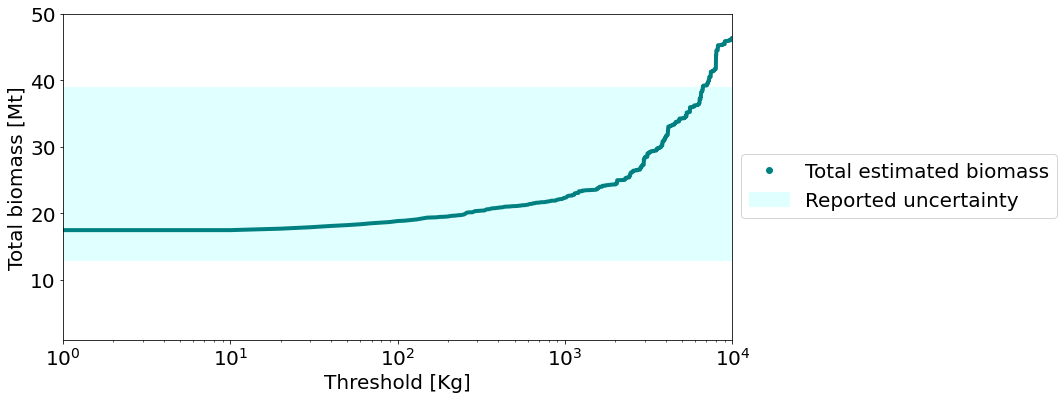

In [456]:
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['hatch.color'] = 'white'
plt.rcParams['hatch.linewidth'] = 5

tot_biomass_list = []
thres_range = range(0,10000,10)
for thres in thres_range:    
    small_bodied_species = to_infer[to_infer.AdultBodyMassG<thres].binomial
    large_bodied_species = to_infer[~to_infer.binomial.isin(small_bodied_species)].binomial

    inferred_pop_w_range_feature_thres = inferred_pop_w_range_feature[inferred_pop_w_range_feature.index.isin(large_bodied_species)]
    inferred_pop_wo_range_feature_thres = inferred_pop_wo_range_feature[inferred_pop_wo_range_feature.index.isin(small_bodied_species)]
    pop_estimates = pd.concat([inferred_pop_w_range_feature_thres, inferred_pop_wo_range_feature_thres])
    pop_estimates = pd.DataFrame(pop_estimates.mean(axis = 1)).rename({0:'pop'}, axis = 1)
    species_mass = all_species_list[all_species_list.binomial.isin(pop_estimates.index)]
    body_mass = species_mass.set_index('binomial')[['mean_mass']]

    biomass_per_species = pd.concat([pop_estimates,body_mass], axis = 1)
    biomass_per_species['biomass_Mt'] = biomass_per_species['pop']*biomass_per_species['mean_mass'] 
    tot_biomass_Mt = biomass_per_species['biomass_Mt'].sum()*10**(-12)+biomass_pop_reports_Mt
    tot_biomass_list = tot_biomass_list+[tot_biomass_Mt]

    
fig, ax = plt.subplots(figsize=(12, 6))
rect = mpatches.Rectangle((-1,tot_biomass_lower_Mt), 10000, tot_biomass_upper_Mt-tot_biomass_lower_Mt, color = 'lightcyan')
ax.add_patch(rect)
ax.plot(thres_range,tot_biomass_list,color = 'teal', linewidth = 4)
ax.set_xlabel("Threshold [Kg]")
ax.set_xlim([1,10000])
ax.set_xscale('log')
ax.set_ylim([1,50])
ax.set_ylabel("Total biomass [Mt]")

legend_elements = [Line2D([0], [0], marker='o', color='w', label = 'Total estimated biomass',markerfacecolor='teal', markersize=8),
                   mpatches.Patch(facecolor='lightcyan', edgecolor='lightcyan',label='Reported uncertainty')]
ax.legend(handles = legend_elements,bbox_to_anchor=(1.5, 0.6))
plt.savefig(path_to_SI_plots+'1kg_thres_sensitivity_analysis.png',bbox_inches='tight')
    

In [95]:
unrepresented_orders = pd.read_csv(path_to_data+'nearest_phylo_order.csv')
binomials_from_unrepresented_orders = np.array(all_species_list[all_species_list.Order.isin(unrepresented_orders.Order)].binomial)
unrepresented_orders_df = pd.DataFrame(biomass_per_species.mean(axis = 1)).rename({0:'biomass'}, axis =1)
unrepresented_orders_df = unrepresented_orders_df[unrepresented_orders_df.index.isin(binomials)]
total_biomass = unrepresented_orders_df.biomass.sum()*10**(-12)
print("The total biomass of species for which orders were assigned based on closest phylogenetic neighbor: "+str(round(total_biomass,1))+ " Mt")

The total biomass of species for which orders were assigned based on closest phylogenetic neighbor: 0.8 Mt


Applying a bayesian search to optimize hyperparameters using the scikit-optimize package.  </br>
You may need to install the scikit-optimize package (we used version 0.9.0). </br>
The version below only runs this code with continous features- running it with all features yields similar results

In [1]:
# from skopt import BayesSearchCV

# data, cat_features, cont_features, label_name = preproc_data(*read_data(path_to_data, True))
# labeled_data = data.loc['labeled']
# labeled_data = labeled_data.assign(log_density=labeled_data.log_pop-labeled_data.log_range)
# feature_scaler, label_scaler, scaled_features, scaled_labels = scale_cont(labeled_data, cont_features, label_name)
# scaled_df = pd.concat([scaled_features, labeled_data[cat_features]], axis=1)

# params = dict()
# params['C'] = (1e-6, 100.0, 'log-uniform')
# params['gamma'] = (1e-6, 100.0, 'log-uniform')
# params['epsilon'] = (1e-6, 100.0, 'log-uniform')
# params['kernel'] = ['poly', 'rbf', 'sigmoid']

# search = BayesSearchCV(estimator=SVR(), search_spaces=params, random_state = 1)
# search.fit(scaled_features, scaled_labels.values.ravel())
# print('Best parameters:')
# print(search.best_params_)

To test how algorithm dependent our results are, we also ran a GradientBoostingRegressor ElasticNetCV 
https://scikit-learn.org/

In [60]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNetCV

rmse_list = np.zeros(1000)
data, cat_features, cont_features, label_name = preproc_data(*read_data(path_to_data, True))
labeled_data = data.loc['labeled']
labeled_data = labeled_data.assign(log_density=labeled_data.log_pop-labeled_data.log_range)
features = pd.concat([labeled_data[cat_features],labeled_data[cont_features]], axis = 1)
labels = labeled_data['log_density']
for state in range(0,1000):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.1,random_state=0)
    reg = ElasticNetCV(random_state=state) 
    reg.fit(X_train, y_train)
    predictions = reg.predict(X_test)
    rmse = math.sqrt(mean_squared_error(predictions, y_test))
    rmse_list[state] = rmse

mean_rmse = np.mean(rmse_list)

# to_infer_gbr = data.loc['not_labeled']
# features = pd.concat([to_infer_gbr[cat_features],to_infer_gbr[cont_features]], axis = 1)
# to_infer_gbr['inferred_density'] = np.exp((reg.predict(features)) + ((round(mean_rmse, 1)**2) / 2) )
# to_infer_gbr['inferred_biomass'] = to_infer_gbr['inferred_density']*to_infer_gbr['body_mass']*to_infer_gbr['range']
# to_infer_gbr['inferred_biomass'].sum()*10**(-12)